<a href="https://colab.research.google.com/github/Marieta3/neuronske_mreze/blob/main/cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
COLAB = True
print("Note: using Google CoLab")
%tensorflow_version 2.x

Mounted at /content/drive
Note: using Google CoLab


In [62]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
import os 
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import time

## Check input data format

170508288/170498071 [==============================] - 13s 0us/step


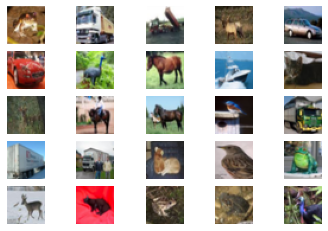

In [3]:
(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [13]:
trainX.shape

(50000, 32, 32, 3)

In [3]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/My Drive'
OUTPUT_PATH = 'output-karina11'
EPOCHS = 10
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


# Concatenate dataset and create labels

In [22]:
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
portraits = np.load(training_binary_path)

training_binary_path = os.path.join(DATA_PATH,
        f'flower-painting_training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
flowers = np.load(training_binary_path)

training_binary_path = os.path.join(DATA_PATH,
        f'religious-painting_training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
religious = np.load(training_binary_path)


In [26]:
training_data = np.vstack((portraits, flowers, religious))

In [27]:
training_data.shape

(14320, 96, 96, 3)

In [28]:
print(portraits.shape)
print(flowers.shape)
print(religious.shape)

(4117, 96, 96, 3)
(1809, 96, 96, 3)
(8394, 96, 96, 3)


In [29]:
4117+1809+8394

14320

## **Labels**
1- Portraits
2- Flowers
3- Religious paintings

In [49]:
portraits_lab = np.full((4117,1), 1, dtype='uint8')
flowers_lab = np.full((1809,1), 2, dtype='uint8')
religious_lab = np.full((8394,1), 3, dtype='uint8')

In [50]:
labels = np.vstack((portraits_lab, flowers_lab, religious_lab))

# Load concatenated dataset


In [4]:
training_binary_path = os.path.join(DATA_PATH,
        f'pfr_training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
training_data = np.load(training_binary_path)

training_binary_path = os.path.join(DATA_PATH,
        f'lab_pfr_training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
labels = np.load(training_binary_path)

In [5]:
labels

array([[1],
       [1],
       [1],
       ...,
       [3],
       [3],
       [3]], dtype=uint8)

In [48]:
trainy

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

# Save dataset and labels

In [52]:
training_binary_path = os.path.join(DATA_PATH,
        f'pfr_training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
print("Saving training image binary...")
np.save(training_binary_path,training_data)

training_binary_path = os.path.join(DATA_PATH,
        f'lab_pfr_training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
print("Saving training image binary...")
np.save(training_binary_path,labels)

Saving training image binary...
Saving training image binary...


In [44]:
#shuffle dataset
def unisonShuffleDataset(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

train_images, lab = unisonShuffleDataset(training_data, labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

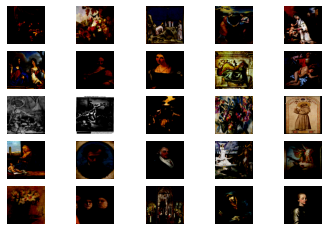

In [19]:
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(train[i])
plt.show()

In [22]:
lab[8]

array([3], dtype=uint8)

In [25]:
def define_discriminator(in_shape=(96,96,3), n_classes=3):
	
    # label input
	in_label = Input(shape=(1,))  #Shape 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50. 
    #This vector of size 50 will be learnt by the discriminator
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024. 
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1
    
    
	# image input
	in_image = Input(shape=in_shape) #32x32x3
	# concat label as a channel
	merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)
    
	# downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model. 
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1
    
	# define model
    ##Combine input label with input image and supply as inputs to the model. 
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        150         ['input_5[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 1, 9216)      470016      ['embedding_2[0][0]']            
                                                                                                  
 input_6 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                            

In [34]:
def define_generator(latent_dim, n_classes=3):
    
	# label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50. 
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
    
	# linear multiplication
	n_nodes = 12 * 12  # To match the dimensions for concatenation later in this step.  
	li = Dense(n_nodes)(li) #1,64
	# reshape to additional channel
	li = Reshape((12, 12, 1))(li)
    
    
	# image generator input
	in_lat = Input(shape=(latent_dim,))  #Input of dimension 100
    
	# foundation for 8x8 image
    # We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    #Note that this part is same as unconditional GAN until the output layer. 
    #While defining model inputs we will combine input label and the latent input.
	n_nodes = 128 * 12 * 12
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((12, 12, 128))(gen) #Shape=8x8x128
	# merge image gen and label input
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model   #Model not compiled as it is not directly trained like the discriminator.

test_gen = define_generator(100, n_classes=3)
print(test_gen.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_23 (Dense)               (None, 18432)        1861632     ['input_24[0][0]']               
                                                                                                  
 embedding_11 (Embedding)       (None, 1, 50)        150         ['input_23[0][0]']               
                                                                                            

In [35]:
def define_gan(g_model, d_model):
	d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.
    
    ## connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  #32x32x3
    
	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [36]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset  
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

In [59]:
def generate_latent_points(latent_dim, n_samples, n_classes=3):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [50]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

In [71]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			
             # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
            # get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)	
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
             # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Print losses on this batch
		print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	#g_model.save('cifar_conditional_generator_25epochs.h5')

In [72]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = [train_images, lab]
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch>1, Batch111/111, d1=0.385, d2=0.201 g=2.757
Epoch>2, Batch111/111, d1=0.553, d2=0.316 g=3.359
Epoch>3, Batch111/111, d1=0.471, d2=0.271 g=2.500
Epoch>4, Batch111/111, d1=0.399, d2=0.304 g=2.698
Epoch>5, Batch111/111, d1=0.347, d2=0.249 g=3.505
Epoch>6, Batch111/111, d1=0.404, d2=0.194 g=3.261
Epoch>7, Batch111/111, d1=0.341, d2=0.368 g=3.785
Epoch>8, Batch111/111, d1=0.283, d2=0.159 g=3.967
Epoch>9, Batch111/111, d1=0.377, d2=0.264 g=3.403
Epoch>10, Batch111/111, d1=0.227, d2=0.178 g=3.998
Epoch>11, Batch111/111, d1=0.324, d2=0.312 g=2.854
Epoch>12, Batch111/111, d1=0.302, d2=0.271 g=3.370
Epoch>13, Batch111/111, d1=0.347, d2=0.418 g=3.174
Epoch>14, Batch111/111, d1=0.328, d2=0.320 g=3.823
Epoch>15, Batch111/111, d1=0.367, d2=0.361 g=3.074
Epoch>16, Batch111/111, d1=0.479, d2=0.281 g=3.506
Epoch>17, Batch111/111, d1=0.486, d2=0.410 g=4.125
Epoch>18, Batch111/111, d1=0.333, d2=0.312 g=3.600
Epoch>19, Batch111/111, d1=0.441, d2=0.337 g=3.322
Epoch>20, Batch111/111, d1=0.520, d2=0.3

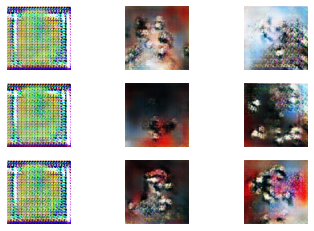

In [77]:
# generate multiple images

latent_points, labels = generate_latent_points(100, 30)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = np.asarray([x for _ in range(10) for x in range(3)])
# generate images
X  = g_model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (3 sets of images, all images in a column should be of same class in the plot)
# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
    
show_plot(X, 3)

In [74]:
g_model.save(os.path.join(DATA_PATH,"1conditional_generator_50epochs_tf"),save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/My Drive/1conditional_generator_50epochs_tf/assets


In [61]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = g_model.predict([noise, labels])

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,OUTPUT_PATH)
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt+1}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [63]:
np.asarray([x for _ in range(10) for x in range(3)])

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2])

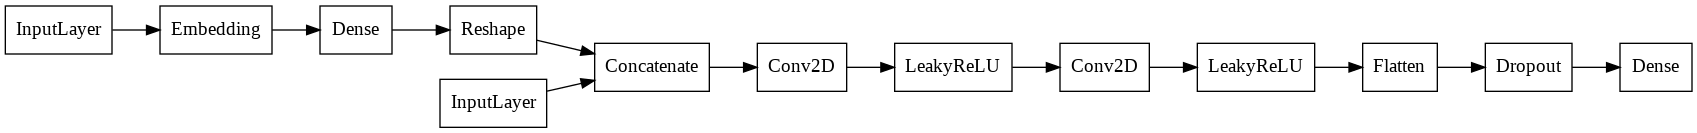

In [112]:
from keras.utils.vis_utils import plot_model
plot_model(d_model, to_file='Dmodel_plot_LR.png', show_shapes=False, show_layer_names=False, rankdir="LR",)

In [78]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 48.4 MB/s 


In [113]:
import visualkeras
visualkeras.layered_view(g_model,legend=True, draw_volume=True)

TypeError: ignored